В этом задании вам необходимо будет:

1. Реализовать формулу подсчета длительности теста, сравнить ее с онлайн калькуляторами (например https://mindbox.ru/tools/ab-test-calculator/ ). При сравнении оценить мощность критерия при указанном изменении и рассчитанном количестве наблюдений в выборке. 

2. Реализовать метод линеаризации. Проверить для него корректность и мощность. Входные данные - синтетически сгенерированные.

3. Реализовать метод CUPED. Проверить для него корректность и мощность. Данные на этапе до A/B теста необходимо сгенерировать один раз, далее синтетически генерировать только часть, связанную с проведением A/B-теста.

In [1]:
from matplotlib import pyplot as plt
from scipy import special,stats
from math import ceil
import numpy as np

In [2]:
ALPHA=0.05 # Вероятность отвергнуть H0
POWER=0.8  # Мощность
EFFECT=0.1 # Ожидаемый абсолютный прирост 10%

Размер выборки: 123
Мощность критерия: 20.40%


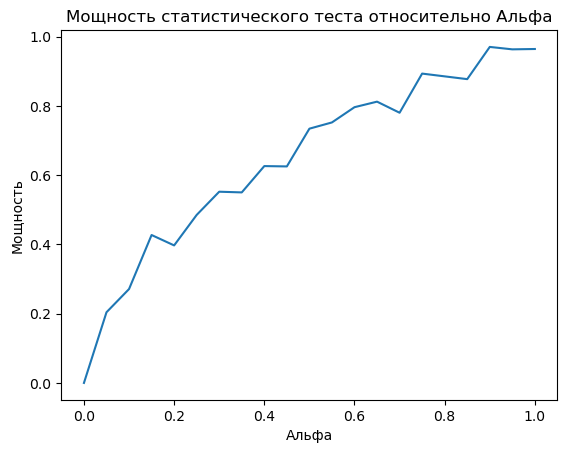

In [3]:
# Функция моделирует мощность критерия
def calc_power(distrib_a, distrib_b, params_a, params_b, num_simulations, alpha):
    type1_error_count = 0
    for _ in range(num_simulations):
        a = distrib_a(**params_a)
        b = distrib_b(**params_b)
        _, p_value = stats.ttest_ind(a, b, alternative='two-sided')
        if p_value < alpha:
            type1_error_count += 1
    return type1_error_count / num_simulations

# Функция для получения групп
def get_group(params_a, params_b, params_view, view_distrib):
    
    views_a = view_distrib(**params_view).astype(int)
    views_b = view_distrib(**params_view).astype(int)
    
    clicks_a = np.random.binomial(views_a, **params_a)
    clicks_b = np.random.binomial(views_b, **params_b)
    
    return clicks_a, views_a, clicks_b, views_b

# Функция расчета длительности эксперимента
def calc_duration(k, effect, sigma2_a, sigma2_b, alpha, beta):
    z_alpha = stats.norm.ppf(1 - alpha/2)
    z_beta = stats.norm.ppf(beta)
    z = z_alpha + z_beta
    n = (k + 1) * z**2 * (sigma2_a + sigma2_b/k) / (effect**2)
    return ceil(n)

# Рассчет длительности теста и размера выборки
p = 0.4
q = 1 - p
p_e = p + EFFECT
q_e = q - EFFECT

assert (p + q) == (p_e + q_e) == 1

sigma2_a = p * q
sigma2_b = p_e * q_e

size = calc_duration(1, EFFECT, sigma2_a, sigma2_b, ALPHA, 1 - POWER)
params_a = {'n': 1, 'p': p, 'size': size//2}
params_b = {'n': 1, 'p': p_e, 'size': size//2}

# Рассчет мощности критерия
power_t = calc_power(
    distrib_a=np.random.binomial,
    distrib_b=np.random.binomial,
    params_a=params_a,
    params_b=params_b,
    num_simulations=1000,
    alpha=ALPHA
)

print(f"Размер выборки: {size}")
print(f"Мощность критерия: {power_t * 100:.2f}%")

powers = []
for alpha in np.arange(0.0, 1+ALPHA, ALPHA):
    power = calc_power(
        distrib_a=np.random.binomial,
        distrib_b=np.random.binomial,
        params_a=params_a,
        params_b=params_b,
        num_simulations=1000,
        alpha=alpha
    )
    powers.append(power)

# Отображаем результаты
plt.plot(np.arange(0.0, 1.05, 0.05), powers)
plt.xlabel('Альфа')
plt.ylabel('Мощность')
plt.title('Мощность статистического теста относительно Альфа')
plt.show()

In [4]:
# Функция моделирует мощность критерия для метода линеаризации

def calc_power_lin(params_a, params_b, params_view, view_distrib, num_simulations, alpha):
    type1_error_count = 0
    type1_error_count_lin = 0
    
    for i in range(num_simulations):
        clicks_a, views_a, clicks_b, views_b = get_group(params_a, params_b, params_view, view_distrib)
        
        cr_a = clicks_a.sum() / views_a.sum()
        a_lin = clicks_a - cr_a * views_a
        b_lin = clicks_b - cr_a * views_b
        
        s, p_value_lin = stats.ttest_ind(a_lin, b_lin, alternative='two-sided')
        if p_value_lin < alpha:
            type1_error_count_lin += 1
        
        a = clicks_a/views_a
        b = clicks_b/views_b
        
        s, p_value = stats.ttest_ind(a, b, alternative='two-sided')
        if p_value < alpha:
            type1_error_count += 1
    
    return type1_error_count_lin / num_simulations, type1_error_count / num_simulations

def print_res(effect, power_t_def, power_t, method):
    print(f"Мощность критерия c эффектом {effect * 100}%:")
    print(f"    указанная {power_t_def * 100:.2f}%")
    print(f"    рассчитанная для {method} {power_t * 100:.2f}%\n")
    
effect = ALPHA
size = 100
p = 0.6

params_view = {'low':10, 'high':15, 'size':size}
params_a = {'p':p, 'size':size}
params_b = {'p':p + effect,'size':size}

power_t, power_t_def = calc_power_lin(
    params_a=params_a,
    params_b=params_b,
    params_view=params_view,
    view_distrib=np.random.uniform,
    num_simulations=1000,
    alpha=ALPHA)
print_res(effect, power_t_def, power_t, "линеаризации")

effect = 0.01
size = 100
p = 0.6

params_view = {'loc': 50, 'scale':5, 'size':size}
params_a = {'p': p, 'size':size}
params_b = {'p':  p + effect, 'size':size}

power_t, power_t_def = calc_power_lin(
    params_a=params_a,
    params_b=params_b,
    params_view=params_view,
    view_distrib=stats.expon.rvs,
    num_simulations=1000,
    alpha=ALPHA)
print_res(effect, power_t_def, power_t, "линеаризации")

effect = 0.25

params_a = {'p': p, 'size':size}
params_b = {'p':  p + effect, 'size':size}

power_t, power_t_def = calc_power_lin(
    params_a=params_a,
    params_b=params_b,
    params_view=params_view,
    view_distrib=stats.expon.rvs,
    num_simulations=1000,
    alpha=ALPHA)
print_res(effect, power_t_def, power_t, "линеаризации")

Мощность критерия c эффектом 5.0%:
    указанная 69.80%
    рассчитанная для линеаризации 69.90%

Мощность критерия c эффектом 1.0%:
    указанная 19.90%
    рассчитанная для линеаризации 19.80%

Мощность критерия c эффектом 25.0%:
    указанная 100.00%
    рассчитанная для линеаризации 100.00%



In [5]:
# Функция для CUPED-метода

def cuped_method(user_a, user_b, distrib, params_a, params_b, num_simulations, alpha):
    type1_error_count = 0
    type1_error_count_def = 0
    for i in range(num_simulations):
        a = distrib(**params_a)
        b = distrib(**params_b)
        
        s, p_value_def = stats.ttest_ind(a, b, alternative='two-sided')
        if p_value_def < alpha:
            type1_error_count_def += 1
        
        theta = np.cov(user_a, a)[0,1]/np.var(user_a)
        
        a_cuped = a - user_a * theta
        b_cuped = b - user_b * theta
        
        s, p_value = stats.ttest_ind(a_cuped, b_cuped, alternative='two-sided')
        
        if p_value < alpha:
            type1_error_count += 1
    
    return type1_error_count / num_simulations , type1_error_count_def/num_simulations

effect = 0.01
loc = 5
scale = 2
size = 100

params_a = {'loc': loc, 'scale':scale, 'size':size}
params_b = {'loc':  loc + loc*effect, 'scale': scale, 'size':size}

a_before = stats.expon.rvs(loc = 5, scale = 2, size = size)
b_before = stats.expon.rvs(loc = 5, scale = 2, size = size)

power_t, power_t_def = cuped_method(
    user_a = a_before,
    user_b = b_before,
    distrib=np.random.normal,
    params_a=params_a,
    params_b=params_b,
    num_simulations=1000,
    alpha=ALPHA)

print_res(effect, power_t_def, power_t, "CUPED")

effect = 0.25

params_a = {'loc': loc, 'scale':scale, 'size':size}
params_b = {'loc':  loc + loc*effect, 'scale': scale, 'size':size}

a_before = stats.expon.rvs(loc = 5, scale = 2, size = size)
b_before = stats.expon.rvs(loc = 5, scale = 2, size = size)

power_t, power_t_def = cuped_method(
    user_a = a_before,
    user_b = b_before,
    distrib=np.random.normal,
    params_a=params_a,
    params_b=params_b,
    num_simulations=1000,
    alpha=ALPHA)

print_res(effect, power_t_def, power_t, "CUPED")

pvalues = []
alphas = np.arange(0.0, 1+ALPHA, ALPHA)
for alpha in alphas:
    power_t, _ = cuped_method(
        user_a=a_before,
        user_b=a_before,
        distrib=np.random.normal,
        params_a=params_a,
        params_b=params_a,
        num_simulations=1000,
        alpha=alpha)
    pvalues.append(power_t)
    
effect = EFFECT

params_a = {'loc': loc, 'scale':scale, 'size':size}
params_b = {'loc':  loc + loc*effect, 'scale': scale, 'size':size}

a_before = stats.expon.rvs(loc = 5, scale = 2, size = size)
b_before = stats.expon.rvs(loc = 5, scale = 2, size = size)

power_t, power_t_def = cuped_method(
    user_a = a_before,
    user_b = b_before,
    distrib=stats.expon.rvs,
    params_a=params_a,
    params_b=params_b,
    num_simulations=1000,
    alpha=ALPHA)

print_res(effect, power_t_def, power_t, "CUPED")

Мощность критерия c эффектом 1.0%:
    указанная 5.80%
    рассчитанная для CUPED 5.90%

Мощность критерия c эффектом 25.0%:
    указанная 99.00%
    рассчитанная для CUPED 99.00%

Мощность критерия c эффектом 10.0%:
    указанная 41.10%
    рассчитанная для CUPED 41.00%

